In [1]:
from scipy import io as spio
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
from keras.backend import tensorflow_backend

print("TensorFlow verison: ", tf.VERSION)
print("Keras version: ", tf.keras.__version__)
print("Channels dimension of image: ", tf.keras.backend.image_data_format())
config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
session = tf.Session(config=config)
tensorflow_backend.set_session(session)

# Loading dataset from MATALB's table
emnist = spio.loadmat("D:\Projects\Jupyter\emnist_letters_dataset\emnist-letters.mat")

# Train samples
X_train = emnist["dataset"][0][0][0][0][0][0]
X_train = X_train.astype(np.float32)

# Train targets
y_train = emnist["dataset"][0][0][0][0][0][1]

# Test samples
X_test = emnist["dataset"][0][0][1][0][0][0]
X_test = X_test.astype(np.float32)

# Test targets
y_test = emnist["dataset"][0][0][1][0][0][1]


Using TensorFlow backend.


TensorFlow verison:  1.13.1
Keras version:  2.2.4-tf
Channels dimension of image:  channels_last


In [2]:
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (124800, 784)
X_test shape:  (20800, 784)
y_train shape:  (124800, 1)
y_test shape:  (20800, 1)


In [3]:
# Reshape X_train and test to (, 28, 28) for visualization
X_train_imgs = X_train.reshape(X_train.shape[0], 28, 28, order="A")
X_test_imgs = X_test.reshape(X_test.shape[0], 28, 28, order="A")

# Reshape from (, 784) to (, 28, 28, 1) input for conv layer
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1, order="A")
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1, order="A")

# Reshape y_train test to 1D array
y_train = y_train.ravel()
y_test = y_test.ravel()

In [4]:
from sklearn.model_selection import train_test_split

# Normalize
X_train /= 255.0
X_test /= 255.0

# Creating samples for validating data
(X_train, X_valid, y_train, y_valid) = train_test_split(X_train, y_train, 
                                                        test_size=0.2, random_state=9)

In [5]:
print("X_train shape: ", X_train.shape)
print("X_valid shape: ", X_valid.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (99840, 28, 28, 1)
X_valid shape:  (24960, 28, 28, 1)
X_test shape:  (20800, 28, 28, 1)


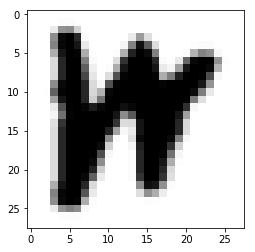

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.imshow(X_train_imgs[0],cmap=plt.cm.binary)
plt.show()

In [7]:
import os
from custom_net import CustomNet


model = CustomNet.build(width=28, height=28, depth=1, num_classes=27)
# Adam(learnig_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer="adam", 
              metrics=["accuracy"])

# Early stop for get best model, monitoring by "val_loss"
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, 
                                           verbose=1, restore_best_weights=True)

# Save
# checkpoint_path = "emnist_letters(tf_keras)/cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)
# cp_callback = k.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, 
#                                           save_best_only=True)

# Fitting model with batch=100, epoch=1000
history = model.fit(X_train, y_train, batch_size=100, 
                    epochs=1000, callbacks=[early_stop], 
                    validation_data=[X_valid, y_valid], verbose=1)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 99840 samples, validate on 24960 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/1000
99840/99840 [==============================] - 31s 307us/sample - loss: 0.8273 - acc: 0.7563 - val_loss: 0.2787 - val_acc: 0.9099
Epoch 2/1000
99840/99840 [==============================] - 28s 280us/sample - loss: 0.2880 - acc: 0.9071 - val_loss: 0.2070 - val_acc: 0.9307
Epoch 3/1000
99840/99840 [==============================] - 28s 280us/sample - loss: 0.2343 - acc: 0.9243 - val_loss: 0.1913 - val_acc: 0.9373
Epoch 4/1000
99840/99840 [==============================] - 28s 279us/sample - loss: 0.2102 - acc: 0.9309 - val_loss: 0.2040 - val_acc: 0.9328
Epoch 5/1000
99840/99840 [==============================] - 28s 280us/sample - loss: 0.1932 - acc: 0.9354 - val_loss: 0.1735 - val_acc: 0.9414


In [8]:
model.save(".\letters_cnn.h5")

In [9]:
# Evalute model
score = model.evaluate(X_test, y_test, batch_size=100)
# Making predictions
predictions = model.predict(X_test)

20800/20800 [==============================] - 2s 73us/sample - loss: 0.1578 - acc: 0.9488


In [10]:
loss, acc = score
print("Loss = ", loss)
print("Accuracy = {:.2f}%".format(acc * 100))

Loss =  0.15784353739908197
Accuracy = 94.88%


In [11]:
from sklearn.metrics import classification_report
from string import ascii_uppercase as a_u
from sklearn.preprocessing import LabelBinarizer

le = LabelBinarizer()
a_u = [a_u[i:i+1] for i in range(0, len(a_u), 1)]
print(classification_report(np.argmax(np.insert(le.fit_transform(y_test), 0, 0, axis=1), axis=1),
                            np.argmax(predictions, axis=1), 
                            target_names=a_u))



              precision    recall  f1-score   support

           A       0.96      0.97      0.97       800
           B       0.99      0.97      0.98       800
           C       0.96      0.99      0.97       800
           D       0.95      0.97      0.96       800
           E       0.98      0.97      0.98       800
           F       0.99      0.97      0.98       800
           G       0.91      0.81      0.86       800
           H       0.94      0.97      0.96       800
           I       0.76      0.76      0.76       800
           J       0.98      0.95      0.97       800
           K       0.99      0.98      0.99       800
           L       0.76      0.77      0.77       800
           M       0.98      1.00      0.99       800
           N       0.98      0.94      0.96       800
           O       0.97      0.98      0.98       800
           P       0.99      0.99      0.99       800
           Q       0.84      0.92      0.88       800
           R       0.96    

In [12]:
import pandas as pd

hist = pd.DataFrame(history.history)

hist

,loss,acc,val_loss,val_acc
0,0.827293,0.756260,0.278655,0.909936
1,0.288032,0.907051,0.207004,0.930689
2,0.234253,0.924309,0.191320,0.937340
3,0.210229,0.930899,0.204004,0.932772
4,0.193242,0.935407,0.173523,0.941426
5,0.179301,0.940054,0.168275,0.943670
6,0.170130,0.942698,0.168782,0.944591
7,0.158336,0.945282,0.166077,0.944872
8,0.150459,0.948468,0.160370,0.947155
9,0.144709,0.950110,0.166258,0.947316


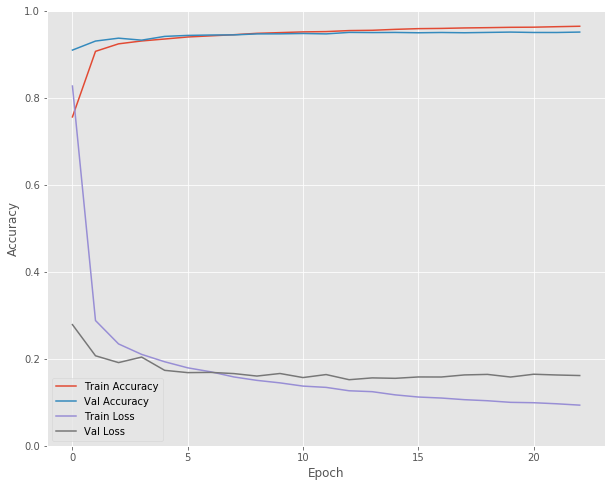

In [13]:
hist['epoch'] = history.epoch

plt.style.use("ggplot")
plt.figure(figsize=(10, 8))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(hist['epoch'], hist['acc'], label='Train Accuracy')
plt.plot(hist['epoch'], hist['val_acc'], label = 'Val Accuracy')
plt.plot(hist['epoch'], hist['loss'], label='Train Loss')
plt.plot(hist['epoch'], hist['val_loss'], label='Val Loss')
plt.ylim([0,1])
plt.legend()

plt.show()

In [14]:
# Making one hot decode from "predictions" array, which contains probabilities
def one_hot_decode(encoded_seq):
    return [np.argmax(vector) for vector in encoded_seq]

preds = np.array(one_hot_decode(predictions))

print(preds.shape)
print(y_test.shape)

(20800,)
(20800,)


In [15]:
# Calculate correct and incorrect results
correct = np.where(preds==y_test)[0]
incorrect = np.where(preds!=y_test)[0]

print("Corresct results =", correct.shape[0])
print("Incorresct results =", incorrect.shape[0])

# Amount of images to show
n_view = incorrect.shape[0]

Corresct results = 19736
Incorresct results = 1064


In [16]:
from numpy.random import permutation

# Taking mixed correct and incorrect ids
idx = permutation(correct)[:n_view]
idx_incorrect = permutation(incorrect)[:n_view]

# Creating arrays with randomed ids
preds_correct = preds[idx]
preds_incorrect = preds[idx_incorrect]

# Images to show
imgs = X_test_imgs[idx]
imgs_incorrect = X_test_imgs[idx_incorrect]

imgs.shape

(1064, 28, 28)

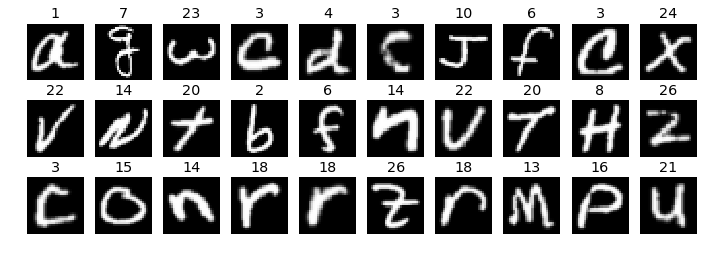

In [17]:
"""
A a = 1
B b = 2
C c = 3
D d = 4
E e = 5
F f = 6
G g = 7
H h = 8
I i = 9
J j = 10
K k = 11
L l = 12
M m = 13
N n = 14
O o = 15
P p = 16
Q q = 17
R r = 18
S s = 19
T t = 20
U u = 21
V v = 22
W w = 23
X x = 24
Y y = 25
Z z = 26 
"""
# Visulization of randomly selected 30 samples
f = plt.figure(figsize=(12,4))

for i in range(30):
    sp = f.add_subplot(3, 10, i+1)
    sp.axis('Off')
    sp.set_title(preds_correct[i])
    img = imgs[i].astype('float32')
    plt.imshow(img, cmap='gray')